In [15]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import io
import os
import random
from PIL import Image
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp

In [16]:
dataset, dataset_info = tfds.load('malaria', with_info=True,as_supervised=True,shuffle_files=True,split=['train'])

In [17]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATA_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO*DATA_SIZE))
    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATA_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATA_SIZE))
    test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATA_SIZE))
    return train_dataset,val_dataset,test_dataset

In [18]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

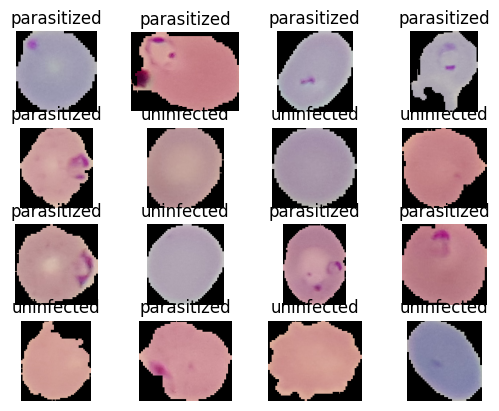

In [19]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1) 
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [20]:
IM_SIZE = 224
def resizing(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [21]:
train_dataset = train_dataset.map(resizing)
val_dataset = val_dataset.map(resizing)
test_dataset = test_dataset.map(resizing)



In [22]:
for image,label in train_dataset.take(1):
    print(image, label)


tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)


In [23]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)


IM_SIZE: 224

In [24]:
train_dataset,val_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [25]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),
    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    BatchNormalization(),

    MaxPool2D(pool_size=2 ,strides=2),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    BatchNormalization(),

    MaxPool2D(pool_size=2 ,strides=2),

    Flatten(),

    Dense(100, activation="relu"),
    BatchNormalization(),

    Dense(10, activation="relu"),
    BatchNormalization(),

    Dense(1, activation="sigmoid"),

])
lenet_model.summary()

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [28]:
lenet_model.compile(optimizer= Adam(learning_rate=0.01),
              loss = BinaryCrossentropy(),
              )
history = lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=20,verbose=1)    


Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 430s 617ms/step - loss: 0.3686 - val_loss: 0.4298
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 424s 615ms/step - loss: 0.1999 - val_loss: 0.6950
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 438s 636ms/step - loss: 0.1733 - val_loss: 0.8784
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 1522s 2s/step - loss: 0.2008 - val_loss: 0.5015
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 346s 503ms/step - loss: 0.1600 - val_loss: 0.2799
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 352s 511ms/step - loss: 0.1509 - val_loss: 0.9797
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 360s 522ms/step - loss: 0.1467 - val_loss: 0.1644
Epoch 8/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 580s 842ms/step - loss: 0.1262 - val_loss: 1.6379
Epoch 9/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 357s 518ms/step - loss: 0.1314 - val_loss: 0.2970
Epoch 10/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 359s 520ms/step - loss: 0.1299 - val_loss: 0.1619
Epoch 11/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 356s 516ms/step - loss: 0.1231 - val_loss: 1.0779
Epoch 12/2

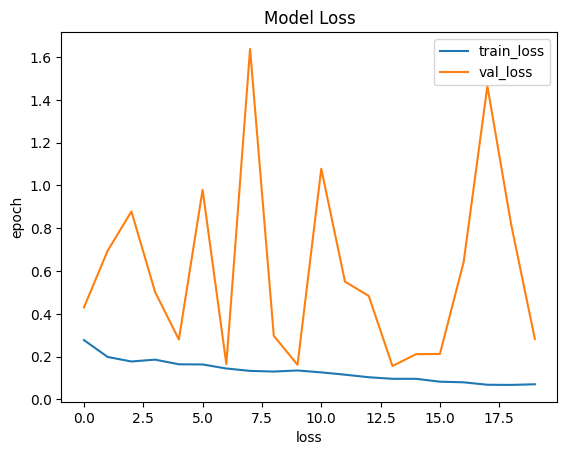

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("loss")
plt.ylabel("epoch")
plt.legend(['train_loss','val_loss'])
plt.show()



In [30]:
test_dataset = test_dataset.batch(1)
test_dataset,train_dataset

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [31]:
lenet_model.evaluate(test_dataset)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - loss: 0.3874


0.39719516038894653

In [32]:
lenet_model.predict(test_dataset.take(1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


0.92022693

In [35]:
def parasite_or_not(x = lenet_model.predict(test_dataset.take(1))[0][0]):
    if (x<0.5):
        return str('P')
    else:
        return str('U')
    
parasite_or_not()    

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


'U'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


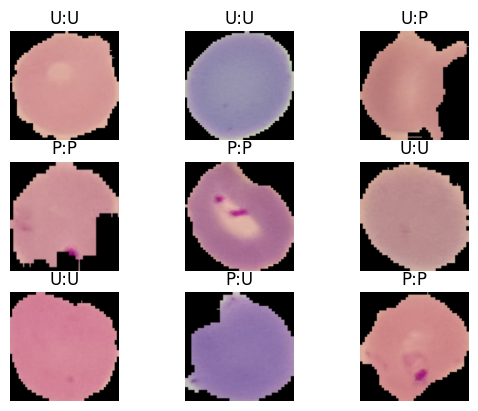

In [36]:
for i ,(image,label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0])) + ':' + str(parasite_or_not(lenet_model.predict(image)[0][0])))
    plt.axis('off')